In [22]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
mnist = fetch_openml('mnist_784', as_frame=False)

In [3]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [4]:
X, y = mnist.data, mnist.target

In [5]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


- 70,000 images, each image has 784 features (as each image is $\, 28 \times 28 \,$ pixels).
- Each feature represents one pixel's intensity, from 0 (white) to 255 (black).
- First 60,000 images are the training samples, and the last 10,000 are the test samples.

<h3>Data splits</h3>

Before performing any kind of EDA, one should separate the data into training and test sets and set the test set aside to avoid data leakage.

In [6]:
X_train, X_test, y_train, y_test = X[:60000,:], X[60000:,:], y[:60000], y[60000:]

In [7]:
print('##### Training data #####')
print(X_train.shape)
print(y_train.shape)
print()
print('##### Test data #####')
print(X_test.shape)
print(y_test.shape)

##### Training data #####
(60000, 784)
(60000,)

##### Test data #####
(10000, 784)
(10000,)


<h3>Visuals</h3>

In [8]:
def display_random_img(X_train, y_train):
    """
    Displays a random image from the training data.
    """
    num_images = X_train.shape[0]
    random_idx = random.randint(0, num_images - 1)
    reshaped_img = X_train[random_idx,:].reshape(28,28)
    label = y_train[random_idx]
    plt.figure(figsize=(6,4))
    plt.imshow(reshaped_img, cmap='binary')
    plt.title(f'Label: {label}');

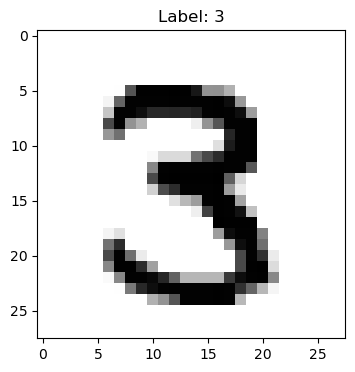

In [9]:
display_random_img(X_train, y_train)

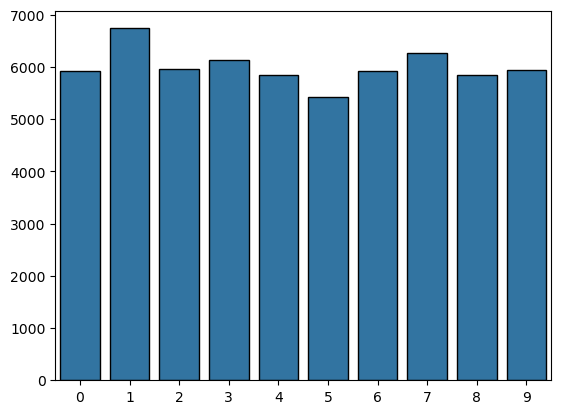

In [10]:
sns.barplot(np.unique(y_train, return_counts=True)[1], edgecolor='black');

In [11]:
(np.unique(y_train, return_counts=True)[1] / y_train.shape[0])[:,np.newaxis].round(4)

array([[0.0987],
       [0.1124],
       [0.0993],
       [0.1022],
       [0.0974],
       [0.0904],
       [0.0986],
       [0.1044],
       [0.0975],
       [0.0992]])

<h3>Multiclass classifier</h3>

In [8]:
X_train_scaled = X_train / 255.0
X_test_scaled = X_test / 255.0

In [9]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train_scaled, y_train)

SGDClassifier(random_state=42)

In [10]:
y_train[0]

'5'

In [11]:
sgd_clf.predict(X_train[0][np.newaxis,:])

array(['3'], dtype='<U1')

In [12]:
sgd_clf.decision_function(X_train[0][np.newaxis,:])

array([[ -654.44810385, -1977.81275445,  -921.63793395,   455.23966841,
        -2533.14293625,   245.71354898, -1147.15249232, -1011.57697215,
         -470.40070275,  -988.99014115]])

- Scikit-learn used the OvR strategy under the hood; since there are 10 classes, it trained 10 binary classifiers.
- `decision_function()` now returns one value per class.
- The label gets assined to the class with the highest score.

In [13]:
sgd_clf.decision_function(X_train[0][np.newaxis,:]).argmax()

np.int64(3)

<h3>Cross-validation</h3>

In [18]:
cross_val_score(estimator=sgd_clf,
                X=X_train_scaled,
                y=y_train,
                cv=3,
                scoring='accuracy')

array([0.90905, 0.90645, 0.91525])

In [20]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train_scaled, y_train)
cross_val_score(dummy_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.11235, 0.11235, 0.1124 ])

- By far better than a dummy classifier that always classifies observations into the majority class.

<h3>Error Analysis</h3>

In [14]:
def plot_cm(y_true, y_pred, title=None, errors_only=False, norm=None, sample_weights=None):
    """
    Args:
        y_true: the true labels
        y_pred: the predicted labels
        title: title for the plot
        errors_only: if True, the correct predictions will be weighted by zero
        norm: type of normalization; if True, normalize by rows, if 'pred', normalize by cols
        sample_weights: weights for the samples
        pred: if pred=True, the CM is normalized my columns rather than by rows
        
    Notes:
        - When errors_only=True, one can see much more clearly the kinds of errors
          the classifier makes.
    """
    if errors_only:
        sample_weights = y_true != y_pred
    
    fig, ax = plt.subplots(figsize=(8,6))
    ConfusionMatrixDisplay.from_predictions(y_true=y_true, 
                                            y_pred=y_pred,
                                            sample_weight=sample_weights,
                                            normalize=norm, 
                                            values_format='.1%',
                                            ax=ax)
    if title is not None:
        ax.set_title(title)

In [15]:
y_pred_train = cross_val_predict(estimator=sgd_clf, 
                                 X=X_train_scaled,
                                 y=y_train,
                                 cv=3)

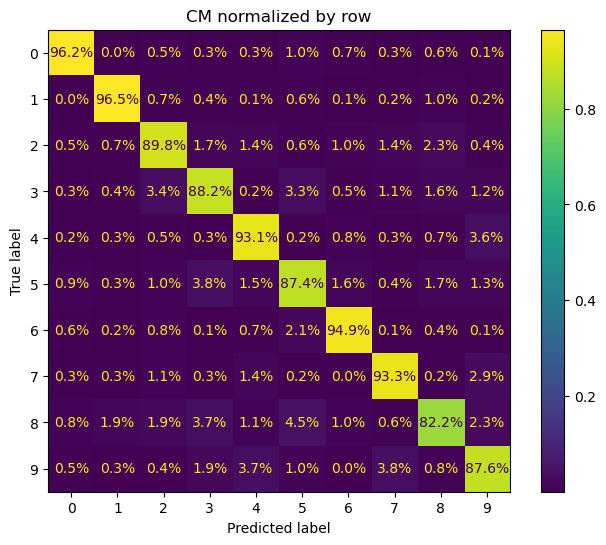

In [16]:
plot_cm(y_train, y_pred_train, title='CM normalized by row', norm='true')

- The model achieved the worst accuracy with the number eights (82.2%).
- The most common error the model made with the images of 8s was to missclassify them as 5s (4.5%).

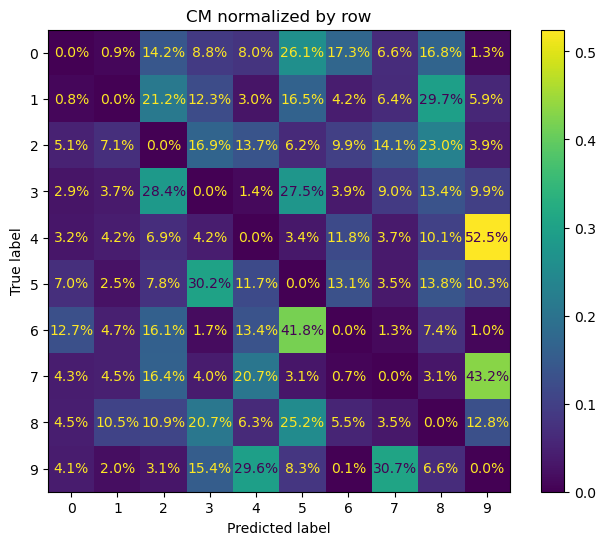

In [19]:
plot_cm(y_true=y_train, 
        y_pred=y_pred_train, 
        errors_only=True,
        norm='true',
        title='CM normalized by row')

The interpretations of the *errors only confusion matrix* need to be considered carefully. Let's consider the interpretation of row **#7** column **#9**, for example.

- **43.2%** does not mean that **43.2%** of all images of 7s were misclassified ad 9s.
- It means that **43.2%** of the *ERRORS* the model made on images of 7s were misclassifications as 9s.
- If you take a look at the previous graph, which also displays the correct predictions, you can see that only **2.9%** of images of 7s were misclassified as 9s.

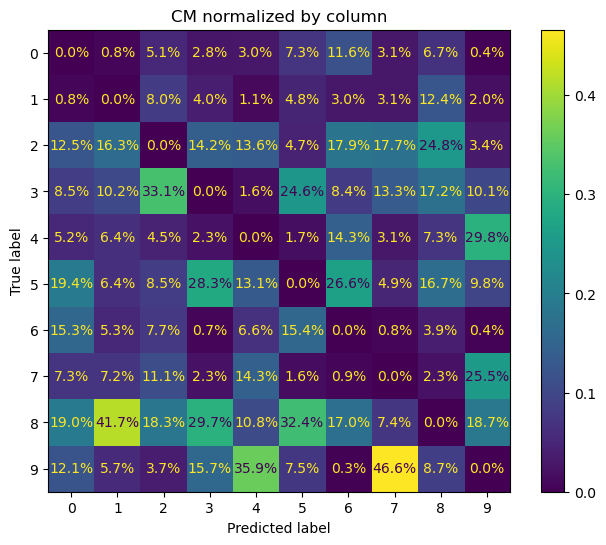

In [21]:
plot_cm(y_true=y_train, 
        y_pred=y_pred_train, 
        errors_only=True,
        norm='pred',
        title='CM normalized by column')

- Interpretation (Row #9, col #7): **46.6%** of misclassified 7s are actually 9s.